In [1]:
# Setup (PyTorch, paths, device, seeds)
import os, random, math, time
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_fscore_support
torch.manual_seed(42)

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# Use the returned path to set base_dir correctly
base_dir = os.path.join(path, "chest_xray")
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

In [3]:
print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)

print("Train dir contents:", os.listdir(train_dir))
print("Val dir contents:", os.listdir(val_dir))
print("Test dir contents:", os.listdir(test_dir))

Train dir: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Val dir: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Test dir: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Train dir contents: ['PNEUMONIA', 'NORMAL']
Val dir contents: ['PNEUMONIA', 'NORMAL']
Test dir contents: ['PNEUMONIA', 'NORMAL']


In [4]:
# Datasets, DataLoaders, class weights (for imbalance)
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 4

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    # normalize to [-1,1] range (since we train from scratch)
    # transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
# TODO: Do we need the 3 randoms ?

# eval_tfms = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
# ])

train_ds = datasets.ImageFolder(train_dir, transform=transform)
val_ds   = datasets.ImageFolder(val_dir,   transform=transform)
test_ds  = datasets.ImageFolder(test_dir,  transform=transform)

print("Classes:", train_ds.classes, "=>", train_ds.class_to_idx)

Classes: ['NORMAL', 'PNEUMONIA'] => {'NORMAL': 0, 'PNEUMONIA': 1}


In [5]:
# CNN model as a class (__init__ + forward)
class PneumoCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(PneumoCNN, self).__init__()
        # feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 14x14

            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 512), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # logits
        )

    def forward(self, x):
        x = self.features(x)
        ## Do we need to reshape ?
        x = self.classifier(x)
        return x  # logits if num_classes=1; shape [B,1]

In [6]:
model = PneumoCNN(num_classes=1)
model

PneumoCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)
model = model.to(device)
EPOCHS = 15
patience = 4
lr = 1e-3

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

device:  cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
# Compute class weights for BCEWithLogitsLoss (pos_weight = N_neg / N_pos for label=1 class)
# In ImageFolder, NORMAL -> 0, PNEUMONIA -> 1 (alphabetical)
train_targets = torch.tensor([y for _, y in train_ds.samples])
pos = (train_targets==1).sum().item()
neg = (train_targets==0).sum().item()
pos_weight = torch.tensor([neg / max(pos,1.0)], dtype=torch.float32)
print(f"Train counts -> NEG(NORMAL)={neg}, POS(PNEUMONIA)={pos}, pos_weight={pos_weight.item():.3f}")

Train counts -> NEG(NORMAL)=1341, POS(PNEUMONIA)=3875, pos_weight=0.346


In [9]:
# Loss, Optimizer, LR scheduler
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))  # robust for class imbalance
## TODO: consider changing to nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True) # monitors val accuracy

In [10]:
# Utilities: train/eval loops
def accuracy_from_logits(logits, targets):
    # logits: [B,1], targets: [B]
    probs = torch.sigmoid(logits).squeeze(1)
    preds = (probs >= 0.5).long()
    correct = (preds == targets.long()).sum().item()
    return correct, preds, probs

def run_one_epoch(model, loader, epochNumber, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    epoch_loss = 0.0
    correct = 0
    n = 0
    all_probs, all_targets = [], []

    for images, targets in tqdm(loader, desc=f"Epoch {epochNumber}/{EPOCHS}"):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.set_grad_enabled(is_train):
            logits = model(images).squeeze(1)
            loss = criterion(logits, targets.float())
            if is_train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

        c, _, probs = accuracy_from_logits(logits.unsqueeze(1), targets)
        epoch_loss += loss.item() * images.size(0)
        correct += c
        n += images.size(0)

        all_probs.append(probs.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = epoch_loss / n
    acc = correct / n
    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # Some environments may lack enough positive/negative samples for AUC early on; guard it
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except Exception:
        auc = float('nan')

    return avg_loss, acc, auc, all_probs, all_targets

In [11]:
# CTraining over epochs with early stopping + checkpoint
best_val_acc = -np.inf
no_improve = 0
ckpt_path = "best_cnn_pneumonia.pt"

history = {"train_loss":[], "train_acc":[], "train_auc":[],
           "val_loss":[], "val_acc":[], "val_auc":[]}

start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_auc, _, _ = run_one_epoch(model, train_loader, epoch, optimizer)
    va_loss, va_acc, va_auc, _, _ = run_one_epoch(model, val_loader, epoch, optimizer=None)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc); history["train_auc"].append(tr_auc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc);   history["val_auc"].append(va_auc)

    # scheduler.step(va_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train: loss {tr_loss:.4f} acc {tr_acc:.4f} auc {tr_auc:.4f} | "
          f"Val:   loss {va_loss:.4f} acc {va_acc:.4f} auc {va_auc:.4f}")

    # Early stopping & checkpoint
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        no_improve = 0
        torch.save({"model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "epoch": epoch}, ckpt_path)
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

print(f"Training finished in {(time.time()-start)/60:.1f} min. Best val acc: {best_val_acc:.4f}")

Epoch 1/15:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/15: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch 01/15 | Train: loss 0.2873 acc 0.8278 auc 0.8879 | Val:   loss 0.7083 acc 0.6875 auc 0.8906


Epoch 2/15:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/15:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Epoch 02/15 | Train: loss 0.1128 acc 0.9103 auc 0.9703 | Val:   loss 0.4940 acc 0.7500 auc 0.8281


Epoch 3/15:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/15:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Epoch 03/15 | Train: loss 0.0960 acc 0.9239 auc 0.9784 | Val:   loss 0.8307 acc 0.6875 auc 0.7344


Epoch 4/15:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/15:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Epoch 04/15 | Train: loss 0.0795 acc 0.9400 auc 0.9851 | Val:   loss 0.4278 acc 0.8125 auc 0.7812


Epoch 5/15:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/15:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Epoch 05/15 | Train: loss 0.0763 acc 0.9427 auc 0.9860 | Val:   loss 0.7033 acc 0.7500 auc 0.9062


Epoch 6/15:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/15:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Epoch 06/15 | Train: loss 0.0668 acc 0.9490 auc 0.9893 | Val:   loss 1.1682 acc 0.5625 auc 0.9062


Epoch 7/15:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/15:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Epoch 07/15 | Train: loss 0.0648 acc 0.9511 auc 0.9899 | Val:   loss 0.8688 acc 0.6875 auc 0.7656


Epoch 8/15:   0%|          | 0/82 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/15:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnin

Epoch 08/15 | Train: loss 0.0590 acc 0.9551 auc 0.9915 | Val:   loss 0.4355 acc 0.6250 auc 0.9531
Early stopping triggered at epoch 8.
Training finished in 11.0 min. Best val acc: 0.8125


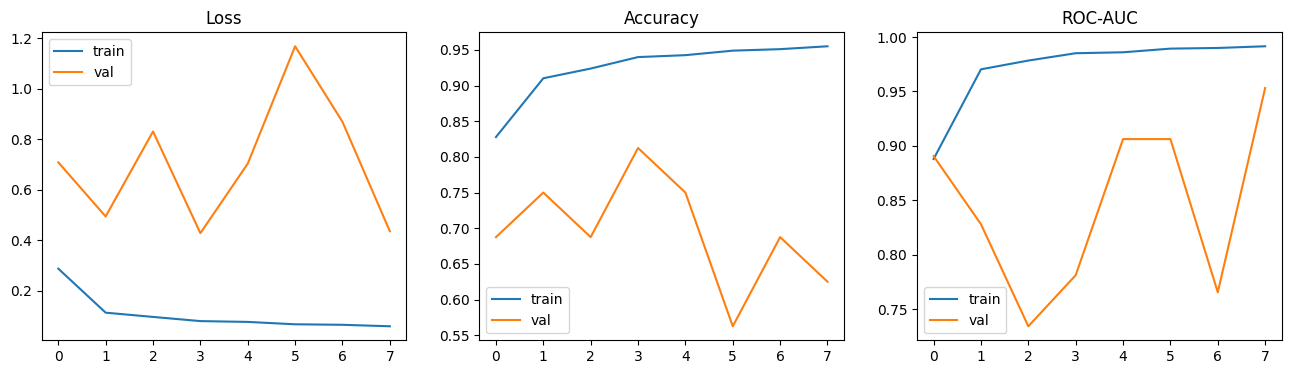

In [12]:
# Load best checkpoint (optional) and plot curves
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])

def plot_curves(h):
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    axs[0].plot(h["train_loss"], label="train"); axs[0].plot(h["val_loss"], label="val")
    axs[0].set_title("Loss"); axs[0].legend()
    axs[1].plot(h["train_acc"], label="train"); axs[1].plot(h["val_acc"], label="val")
    axs[1].set_title("Accuracy"); axs[1].legend()
    axs[2].plot(h["train_auc"], label="train"); axs[2].plot(h["val_auc"], label="val")
    axs[2].set_title("ROC-AUC"); axs[2].legend()
    plt.show()

plot_curves(history)

Epoch 1/15:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/15: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


test pres (first 10): [0.23138583 0.33699474 0.9441196  0.4653809  0.17738543 0.02362957
 0.5241689  0.77883536 0.32696643 0.4708758 ]
TEST — loss: 0.3488 | acc: 0.8381 | auc: 0.9237
Confusion Matrix:
 [[158  76]
 [ 25 365]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.8634    0.6752    0.7578       234
   PNEUMONIA     0.8277    0.9359    0.8785       390

    accuracy                         0.8381       624
   macro avg     0.8455    0.8056    0.8181       624
weighted avg     0.8411    0.8381    0.8332       624



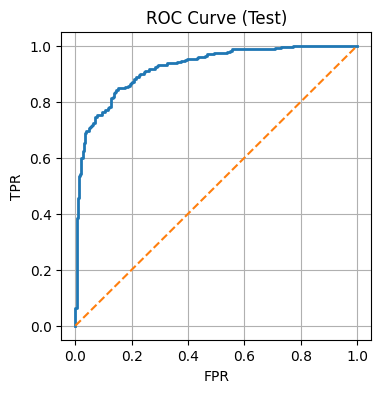

In [13]:
# Final test evaluation + confusion matrix, precision/recall/F1
test_loss, test_acc, test_auc, probs, targets = run_one_epoch(model, test_loader, 1, optimizer=None)
print(f"test pres (first 10): {probs[:10]}")
## TODO: consider using a threshold other than 0.5
preds = (probs >= 0.5).astype(int)

print(f"TEST — loss: {test_loss:.4f} | acc: {test_acc:.4f} | auc: {test_auc:.4f}")

cm = confusion_matrix(targets, preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n",
      classification_report(targets, preds, target_names=test_ds.classes, digits=4))

# Quick ROC curve
fpr, tpr, _ = roc_curve(targets, probs)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve (Test)')
plt.grid(True); plt.show()

In [14]:
# Inference helper (predict on a few samples)
from PIL import Image

def predict_image(path, model, tfms=transform):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logit = model(x)
        prob = torch.sigmoid(logit).item()
    pred = int(prob >= 0.5)
    return prob, pred  # probability of PNEUMONIA, predicted label (0 normal / 1 pneumonia)

# Example:
# p, yhat = predict_image(os.path.join(test_dir, "PNEUMONIA", os.listdir(os.path.join(test_dir,"PNEUMONIA"))[0]), model)
# print(p, yhat)


In [15]:
# TODO: consider adding Visualizations like the R3